# Paradoja de Monty Hall; Simulación & Predictive Modeling.

## Introducción.
La paradoja de Monty Hall es un problema clásico de probabilidad que proviene de un programa de televisión estadounidense llamado "Let's Make a Deal", presentado por Monty Hall. El problema se presenta de la siguiente manera:

Estás en un concurso donde tenemos tres puertas cerradas, detrás de una hay un premio y de las otras dos una cabra (o algo sin valor, se dicen cabras porque así era originalmente). Como concursante has de elegir una puerta al azar, que al seleccionarla el presentador del concurso, que sabe donde está el premio, te abre una de las otras dos puertas en la cual te muestra que hay una cabra en ella, después de ello, te hace la siguiente pregunta: 

*¿Te mantienes con la puerta que elegiste inicialmente, o quieres cambiar a la otra puerta que se encuentra cerrada?*

Aunque parece que cambiar de puerta no debería generar ninguna diferencia en las probabilidades de ganar el premio, la mejor estrategia es siempre cambiar de puerta. Al cambiar de puerta, tus probabilidades de ganar el premio aumentan de 1/3 a 2/3.

Con esta premisa, se hará una simulación que replique el experimento un número de veces determinado, y se realizará un sencillo modelado de Machine Learning del experimento con Scikit-Learn, que se entrenará para predecir las probabilidades de ganar el premio y se evaluará como afecta la decisión de cambiar de puerta o no.

## Simulación y Diseño del Experimento.

Importamos y cargamos las librerías necesarias para este apartado.

In [1]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
import warnings
warnings.filterwarnings("ignore")

Creamos el diccionario con los posibles distintos sucesos del experimento. Entendemos por victoria cuando tras la decisión final de cambiar de puerta o no, la puerta seleccionada contiene el premio, y por derrota, viceversa.

In [3]:
resultados = {
    'Victoria sin cambio de puerta': 0,
    'Victoria con cambio de puerta': 0,
    'Derrota sin cambio de puerta': 0,
    'Derrota con cambio de puerta': 0,
}

Definimos la función experimento según las características de la Paradoja de Monty-Hall, donde tenemos que n será igual al número de puertas establecidas para el concurso.

In [4]:
def experimento(n):
    puertas = range(1, n + 1)
    premio = random.choice(puertas)
    seleccion = random.choice(puertas)

    opciones_no_premio = [puerta for puerta in puertas if puerta != premio and puerta != seleccion]    
    no_premio = random.sample(opciones_no_premio, random.randint(1, n-2))
    puertas_descartadas = len(no_premio)

    opciones_sin_no_premio = [puerta for puerta in puertas if puerta not in no_premio]
    
    # Con el siguiente condicional se quiere aleatorizar por igual la decisión de cambiar de puerta
    if random.random() < 0.5:
        nueva_seleccion = seleccion
    else:
        otras_opciones = [puerta for puerta in opciones_sin_no_premio if puerta != seleccion]
        nueva_seleccion = random.choice(otras_opciones)

    return puertas, premio, seleccion, puertas_descartadas, nueva_seleccion

Realizamos la simulación del experimento según un número de iteraciones establecido y n = 3 puertas.

In [5]:
iteraciones = 10000

for i in range(iteraciones):
    _, premio, seleccion, _, nueva_seleccion = experimento(3)

    if nueva_seleccion == seleccion:
        if nueva_seleccion == premio:
            resultados['Victoria sin cambio de puerta'] += 1
        else:
            resultados['Derrota sin cambio de puerta'] += 1
    else:
        if nueva_seleccion == premio:
            resultados['Victoria con cambio de puerta'] += 1
        else:
            resultados['Derrota con cambio de puerta'] += 1

Representamos y visualizamos los resultados de las iteraciones del experimento.

In [6]:
resultados_pd = pd.DataFrame(list(resultados.items()), columns=['Suceso', 'Cantidad'])

print(resultados_pd.to_string(index=False))

                       Suceso  Cantidad
Victoria sin cambio de puerta      1730
Victoria con cambio de puerta      3334
 Derrota sin cambio de puerta      3268
 Derrota con cambio de puerta      1668


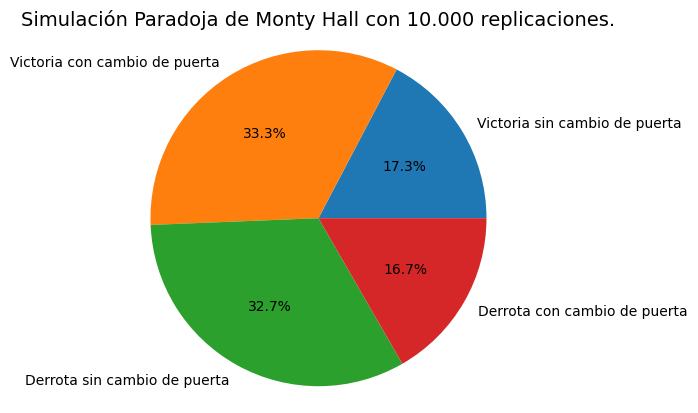

In [7]:
labels = list(resultados.keys())
sizes = list(resultados.values())

plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Simulación Paradoja de Monty Hall con 10.000 replicaciones.', fontsize=14)
plt.axis('equal')

plt.savefig("assets/monty_hall_pie.png", bbox_inches='tight')
plt.show()

Observando los resultados tras las 10.000 replicaciones del experimento, es cierto que al cambiar de puerta, las probabilidades de ganar el premio aumentan de 1/3 a 2/3. Esto lo podemos ver tanto comparando los sucesos 'Victoria con cambio de puerta' y 'Victoria sin cambiar de puerta', como comparando los sucesos 'Victoria con cambio de puerta' y 'Derrota con cambio de puerta'.

## Modelización Predictiva - ML.

A continuación, se va hacer uso de las técnicas y modelos de Machine Learning para captar las interacciones entre las distintas variables que juegan en el problema. Esto se abordará mediante la generalización de la paradoja como ya se ha comentado, de forma que en cada iteración tendremos un número máximo *n* de puertas y el presentador descartará *m* puertas en vez de solo 1, además, se aleatorizó la decisión de cambio de puerta del concursante. 

Para afrontar este nuevo problema, el modelo adecuado de Machine Learning entenderá e identificará las dinámicas y relaciones intrínsecas de las variables que interfieren en el problema para evaluar que tan importante es la decisión de cambiar de puerta para ganar el premio.

El resultado de la simulación expuesto anteriormente nos sirve de entrada para esta generalización, mediante la construcción de un dataframe que esté estructurado con las variables siguientes: 

• "Puertas_Juego", determina el número de puertas cerradas al empezar el juego.<br>
• "Puertas_Descartadas", número de puertas en las cuales el presentador mostró una cabra tras la elección inicial del concursante.<br>
• "Cambio_Puerta", para indicar si cambió de puerta (0 = No cambió, 1 = Sí cambió).<br>
• "Premio", para evaluar si ganó el premio (0 = Perdió, 1 = Ganó).<br>

La construcción de este dataframe viene dado por la función siguiente:

In [8]:
def generar_datos(n, iteraciones):
    datos = []
    for i in range(iteraciones):
        puertas, premio, seleccion, puertas_descartadas, nueva_seleccion = experimento(random.randint(3, n))
        
        Puertas_Juego = len(puertas)
        Premio = 1 if nueva_seleccion == premio else 0
        Cambio_Puerta = 1 if nueva_seleccion != seleccion else 0

        datos.append([Puertas_Juego, puertas_descartadas, Cambio_Puerta, Premio])
    
    return pd.DataFrame(datos, columns=['Puertas_Juego', 'Puertas_Descartadas' ,'Cambio_Puerta', 'Premio'])

Generamos, guardamos y visualizamos el dataframe con los datos con los que se hará la división en conjunto de entrenamiento y prueba, para posteriormente entrenar y evaluar el modelo.

In [9]:
#df_MH = generar_datos(10, 10000)

#df_MH.to_csv('../data/df_MontyHall.csv', index=False)

In [10]:
df_MH = pd.read_csv('../data/df_MontyHall.csv')

df_MH.tail()

,Puertas_Juego,Puertas_Descartadas,Cambio_Puerta,Premio
9995,7,3,0,0
9996,7,5,0,0
9997,5,3,1,1
9998,7,2,0,1
9999,6,4,1,1


Hay que hacer hincapié en que este problema presentará una complejidad para el modelo de ML que viene dada por la construcción de las variables del dataframe mediante procesos totalmente aleatorios, donde el factor que ha de captar el modelo de ML para predecir correctamente ganar o no ganar el premio, viene dado por la intervención del presentador al abrir puertas posteriormente a la elección inicial, y a la toma de decisión del concursante de cambiar o no cambiar de puerta, que la importancia de esta última variable, es la que se evaluará posteriormente. 

Para la elección del modelo más correcto, debido a esta complejidad que presenta el problema, se recurrirá al Random Forest, ya que es un modelo que fácilmente puede capturar las interacciones no lineales (aleatorias) entre variables para explicar la variable objetivo Premio en función de las varaibles predictoras.

Antes de continuar con el modelo, quiero mostrar la tabla cruzada de la variable Cambio_Puerta y Premio.

In [11]:
pd.crosstab(df_MH['Cambio_Puerta'], df_MH['Premio'])

Premio,0,1
Cambio_Puerta,,
0,4064,849
1,2792,2295


### Modelo de Clasificación Random Forest.

Separamos en **y** la variable objetivo y en **X** las predictoras, en este caso solo tenemos una variable predictora debido a la simplicidad a la que hemos reducido el experimento. Luego, realizamos la división de datos en conjuntos de un 80% para el entrenamiento y un 20% para la prueba.

In [12]:
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

In [13]:
X = df_MH[['Puertas_Juego', 'Puertas_Descartadas', 'Cambio_Puerta']]
y = df_MH['Premio']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=61)

Entrenamos el modelo según el clasificador Random-Forest. Posteriormente evaluamos el modelo.

In [14]:
modelo = RandomForestClassifier(n_estimators=10, random_state=61)
modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Reporte de clasificación:\n {classification_report(y_test, y_pred)}")

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.80      0.92      0.85      1385
           1       0.72      0.48      0.58       615

    accuracy                           0.78      2000
   macro avg       0.76      0.70      0.72      2000
weighted avg       0.78      0.78      0.77      2000



Observamos que tenemos una *exactitud* del modelo de un 78 %. El modelo es bastante preciso en predecir la clase 0 (No gana el premio), con una precisión del 80% y un recall del 92%. Para la clase 1 (Ganar el premio), el modelo tiene un buen nivel de precisión (72%), pero un recall bastante más bajo (48%). Esto significa que el modelo no está identificando correctamente la mayoría de los casos donde realmente se gana el premio, esto es lógico debido a lo anteriormente mostrado en la tabla cruzada realizada previamente al modelo, ya que existe un ligero sesgo consecuencia de la aleatoriedad  mediante la que se ha construido el dataframe del experimento.

Para tener una mejor visualización de esto, representemos la matriz de confusión del modelo.

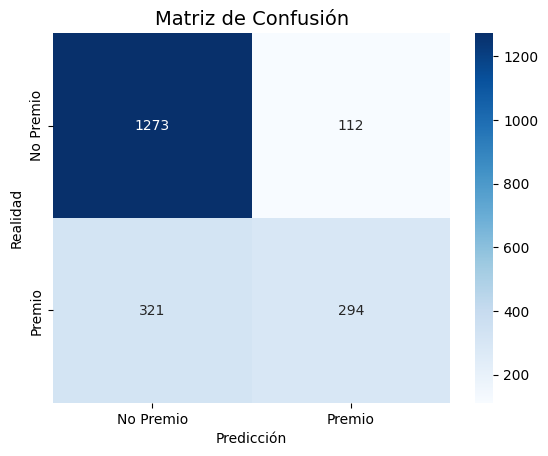

In [15]:
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, 
            fmt='d', 
            cmap='Blues', 
            xticklabels=['No Premio', 'Premio'], 
            yticklabels=['No Premio', 'Premio'])
plt.title('Matriz de Confusión', fontsize=14)
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()

Aunque el modelo tiene una buena exactitud general (78%), su desempeño es desigual entre las clases de Premio, ya que está muy sesgado hacia la clase 0, esto es consecuencia de falta de balance en los datos. De igual modo, se puede afirmar que tienen un buenca capcidad predictiva para ambas clases.

In [16]:
y_prob = modelo.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

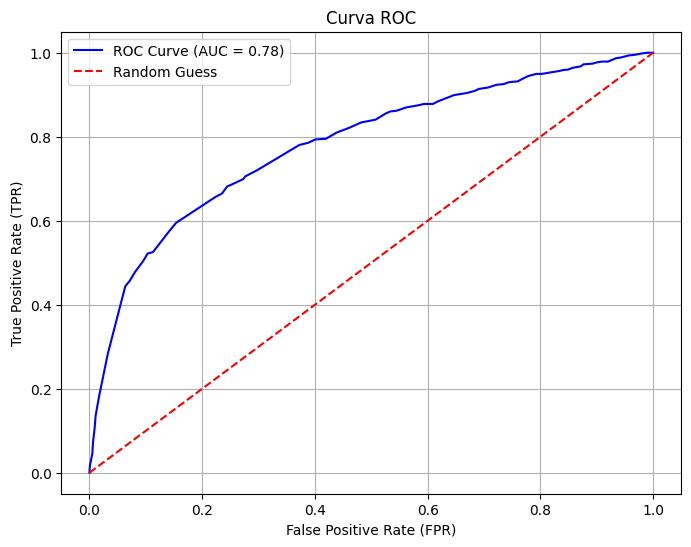

In [17]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="red", label="Random Guess")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Curva ROC")
plt.legend()
plt.grid(True)
plt.show()

Aunque exista sesgo hacia la clase 0 de Premio, el área bajo la curva ROC sigue siendo una métrica robusta para la predicción de las clases de la variable *'Premio'*, un AUC de 0.78 indica que el modelo tiene un buen poder de discriminación en general, pero no da información específica sobre el rendimiento en la clase minoritaria.

Por último, se representa gráficamente cómo la variable Cambio_Puerta afecta la probabilidad de ganar según el modelo.

In [18]:
visualizacion_df_MH = pd.DataFrame({'Cambio_Puerta': X_test['Cambio_Puerta'],
                                   'Probabilidad_Predicha': y_prob})

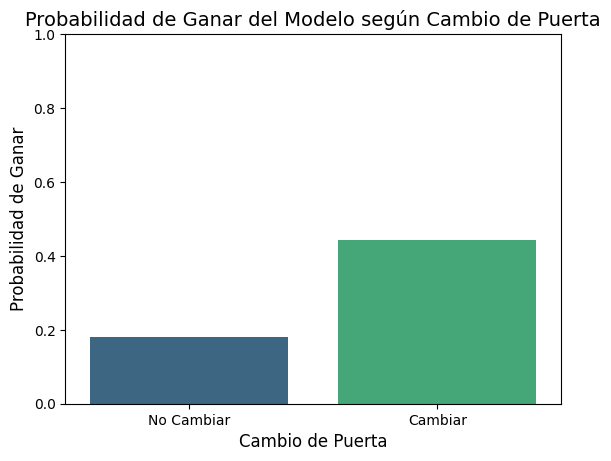

In [19]:
probabilidades_promedio = visualizacion_df_MH.groupby('Cambio_Puerta')['Probabilidad_Predicha'].mean()

sns.barplot(x = probabilidades_promedio.index,
            y = probabilidades_promedio.values,
            palette ='viridis')

plt.title('Probabilidad de Ganar del Modelo según Cambio de Puerta', fontsize = 14)
plt.xlabel('Cambio de Puerta', fontsize = 12)
plt.ylabel('Probabilidad de Ganar', fontsize = 12)
plt.xticks([0, 1], labels=['No Cambiar', 'Cambiar'])
plt.ylim(0, 1)

plt.savefig("assets/winningCambio_Puerta.png", bbox_inches='tight')
plt.show()

En este último gráfico se tiene la última conclusión a la que se quería llegar: El modelo toma la clase 1 (Cambia de puerta) de la variable Cambio_Puerta como una categoría que predice la clase 1 (Gana premio) de la variable Premio mucho mejor que la clase 0 (No cambia de puerta) de la variable Cambio_Puerta.

Igualmente quiero mostrar la probabilidad de perder del modelo según Cambio_Puerta.

In [20]:
y_prob_perder = modelo.predict_proba(X_test)[:, 0]

visualizacion_df_MH = pd.DataFrame({'Cambio_Puerta': X_test['Cambio_Puerta'],
                                   'Probabilidad_Perdida': y_prob_perder})

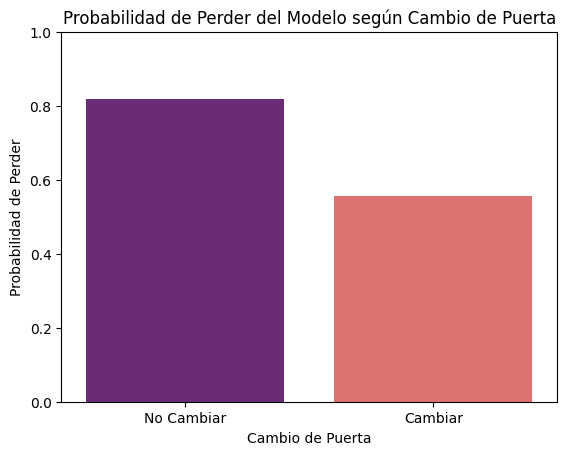

In [21]:
probabilidades_promedio_perder = visualizacion_df_MH.groupby('Cambio_Puerta')['Probabilidad_Perdida'].mean()

sns.barplot(
    x=probabilidades_promedio_perder.index,
    y=probabilidades_promedio_perder.values,
    palette='magma'
)

plt.title('Probabilidad de Perder del Modelo según Cambio de Puerta')
plt.xlabel('Cambio de Puerta')
plt.ylabel('Probabilidad de Perder')
plt.xticks([0, 1], labels=['No Cambiar', 'Cambiar'])
plt.ylim(0, 1)
plt.show()

Como conlusión final sobre la aplicación del modelado de ML, mediante simulación de numerosos casos del experimento con distintas características respecto al número de puertas y puertas abiertas tras la elección inicial, el modelo también "entiende" que cambiar de puerta es la mejor decisión para ganar el premio.

Dejo una última propuesta para el lector, ¿en que cambiaría la interpretación del modelo si incrementamos el número de puertas *n*, por ejemplo, de 10 a 100?, ¿en que afectaría el sesgo a las métricas respecto al expuesto en este notebook? :) 

## Autor: Alfonso Guisado González